In [1]:
# default_exp models_phenom

# Packages

In [1]:
#export
import numpy as np
from stochastic.processes.noise import FractionalGaussianNoise as FGN
import warnings

In [2]:
import matplotlib.pyplot as plt

# Class constructor

In [3]:
#export
class models_phenom():
    def __init__(self):
        '''Constructor of the class''' 
        # We define here the bounds of the anomalous exponent and diffusion coefficient
        self.bound_D = [0, 1e12]
        self.bound_alpha = [0, 1.999]
        
        # We also define the value in which we consider directed motion
        self.alpha_directed = 1.9
        
        # Diffusion state labels: the position of each type defines its numerical label
        # i: immobile/trapped; c: confined; f: free-diffusive (normal and anomalous); d: directed
        self.lab_state = ['i', 'c', 'f', 'd']

# FBM displacements generator

In [4]:
#export
class models_phenom(models_phenom):
    
    @staticmethod
    def disp_fbm(alpha, D, T, deltaT = 1):
        ''' Generates normalized Fractional Gaussian noise. This means that, in 
        general:
                            <x^2(t)> = 2·D·t^alpha
        and in particular:
                            <x^2(t = 1)> = 2·D 
        
        '''
        
        # Generate displacements
        disp = FGN(hurst = alpha/2).sample(n = T)
        # Normalization factor
        disp *= np.sqrt(T)**(alpha)
        # Add D
        disp *= np.sqrt(2*D*deltaT)        
        
        return disp

### Properties of FBM

In [88]:
from andi_datasets.analysis import msd_analysis, vacf
from tqdm.auto import tqdm

T = int(2e2)
alphas = np.linspace(0.2, 1.9, 40)
D = 0.5
reps = int(1e4)
tmsd_a = np.zeros((len(alphas), reps))
exp_a = np.zeros((len(alphas), 100))

taus = np.arange(0, 100)
vacf_a = np.zeros((len(alphas[alphas < 1]), len(taus)))

for idx_a, alpha in enumerate(tqdm(alphas)):
    trajs = []
    for rep in range(reps):
        
        disp = models_phenom().disp_fbm(alpha, D, T)
        # Generate trajectory
        traj = np.cumsum(disp)
        trajs.append(traj)        
        # Calculate tMSD(tlag = 1)
        tmsd_a[idx_a, rep] = msd_analysis().tamsd(traj, t_lags = [1]) 
        if rep < 100:                
            # Calculate exponent
            exp_a[idx_a, rep] = msd_analysis().get_exponent(traj)
    
    if alpha < 1:
        trajs = np.vstack(trajs)
        vacf_a[idx_a, :] = vacf(trajs = trajs, delta_t = 1, taus = taus) 

  0%|          | 0/40 [00:00<?, ?it/s]

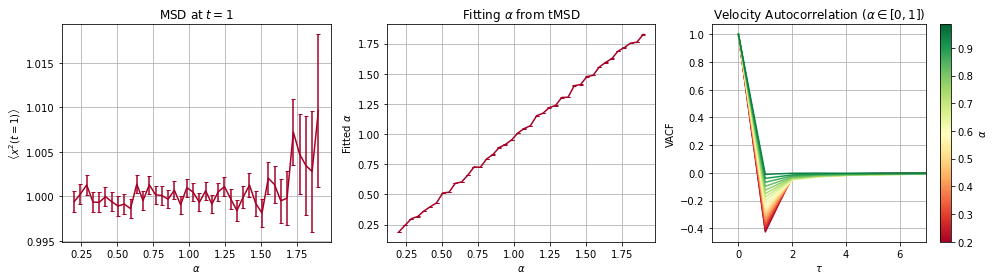

In [89]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)

ax[1].errorbar(alphas, exp_a.mean(1), yerr=exp_a.std(1)/np.sqrt(reps), capsize=2, color = plt.cm.RdYlGn(0))
plt.setp(ax[1], ylabel = r'Fitted $\alpha$', xlabel = r'$\alpha$', title = r'Fitting $\alpha$ from tMSD')
ax[1].grid()

ax[0].errorbar(alphas, tmsd_a.mean(1), yerr=tmsd_a.std(1)/np.sqrt(reps), capsize=2, c = plt.cm.RdYlGn(0))
plt.setp(ax[0], ylabel = r'$\left < x^2(t=1) \right>$', xlabel = r'$\alpha$', title = r'MSD at $t=1$')
ax[0].grid()

for idxv, va in enumerate(vacf_a):
    ax[2].plot(taus, va, c = plt.cm.RdYlGn(idxv/vacf_a.shape[0]));
plt.setp(ax[2], xlim = (-1 , 7), xlabel = r'$\tau$', ylabel = 'VACF', title = r'Velocity Autocorrelation ($\alpha\in[0,1]$)')
ax[2].grid()

import matplotlib.colors as mcolors
vec = alphas[alphas < 1]
normalize = mcolors.Normalize(vmin=vec.min(), vmax=vec.max())
colormap = plt.cm.RdYlGn
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(vec)
cbar = fig.colorbar(scalarmappaple, ax = ax[2])
cbar.set_label(r'$\alpha$')

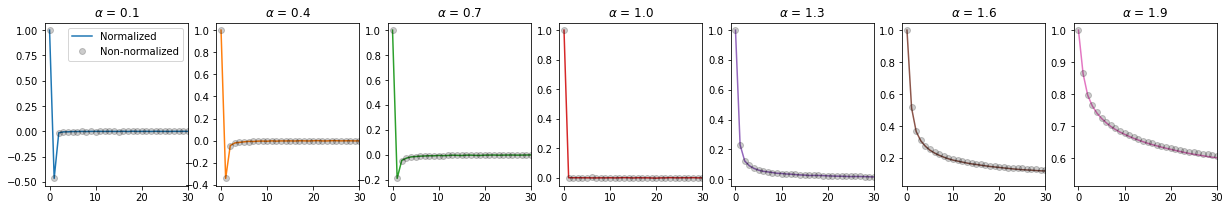

In [79]:
deltats = [1]
taus = np.arange(0, 100)
alphas = np.arange(0.1, 1.91, 0.3)
reps = int(1e4)

fig, ax = plt.subplots(1, len(alphas), figsize = (len(alphas)*3, 3))

for idxa, alpha in enumerate(alphas):
    trajs = np.vstack([np.cumsum(models_phenom().disp_fbm(alpha, D, 200)) for _ in range(reps)])
    trajs_n = np.vstack([np.cumsum(FGN(hurst = alpha/2).sample(n = T)) for _ in range(reps)])

    for deltat in deltats:  
        v = vacf(trajs, deltat, taus)        
        vn = vacf(trajs_n, deltat, taus)        
        ax[idxa].plot(taus/deltat, v.flatten(), '-', c = f'C{idxa}', label = 'Normalized')
        ax[idxa].plot(taus/deltat, vn.flatten(), 'o', alpha = 0.2, c = 'k', label = 'Non-normalized')
        ax[idxa].set_title(fr'$\alpha$ = {np.round(alpha,1)}')
ax[0].legend()   
plt.setp(ax, xlim = (-1, 30));

# Sampling diffusion properties 
In some cases, we may need to sample the diffusion parameters of a particle with restrictions on the distribution and distance between parameters of each state. This following function returns the correct values given the necessary contrainsts

In [6]:
#export
from andi_datasets.utils_trajectories import gaussian

class models_phenom(models_phenom):
    
    @staticmethod
    def _constraint_alpha(alpha_1, alpha_2, epsilon_a):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        return alpha_1 - alpha_2 < epsilon_a
    
    @staticmethod
    def _constraint_d(d1, d2, gamma_d):
        ''' Defines the metric for constraining the changes in anomalous
        exponent'''
        if gamma_d < 1:
            return d2 > d1*gamma_d
        if gamma_d > 1:
            return d2 < d1*gamma_d
    
    @staticmethod
    def _sample_diff_parameters(alphas, Ds, num_states,
                                epsilon_a, gamma_d):
        '''        
        Args:
            :alphas (list): list containing the parameters to sample anomalous exponent
            in state (adapt to sampling function).
            :Ds (list): list containing the parameters to sample the diffusion coefficient
            in state (adapt to sampling function).
            :num_states (int): number of diffusive states.
            
            :epsilon_a (float): minimum distance between anomalous exponents of various states.
            
                epsilon workflow: we check val[i] - val[i-1] < epsilon
                    if you want that val[i] > val[i-1]: epsilon has to be positive
                    if you want that val[i] < val[i-1]: epsilon has to be negative
                    if you don't care: epsilon = 0
                
            :gamma_d (float): factor between diffusion coefficient of various states.
            
                gamma workflow: 
                    for gamma < 1: val[i] < val[i-1]*gamma
                    for gamma > 1: val[i] > val[i-1]*gamma
                    for gamma = 1: no check
                      
        '''

        
        alphas_traj = []
        Ds_traj = []
        for i in range(num_states): 

            # for the first state we just sample normally
            if i == 0:
                alphas_traj.append(float(gaussian(alphas[i], bound = models_phenom().bound_alpha)))
                Ds_traj.append(float(gaussian(Ds[i], bound = models_phenom().bound_D)))
           
            # for next states we take into account epsilon distance between diffusion
            # parameter
            else:
                ## Checking alpha
                alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))
                D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))

                if epsilon_a[i-1] != 0:
                    idx_while = 0
                    while models_phenom()._constraint_alpha(alphas_traj[-1], alpha_state, epsilon_a[i-1]):
                    #alphas_traj[-1] - alpha_state < epsilon_a[i-1]:
                        alpha_state = float(gaussian(alphas[i], bound = models_phenom().bound_alpha))                        
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct alpha for state {i} in 100 steps. State distributions probably too close.')

                alphas_traj.append(alpha_state)
                
                ## Checking D
                if gamma_d[i-1] != 1:    
                    
                    idx_while = 0
                    while models_phenom()._constraint_d(Ds_traj[-1], D_state, gamma_d[i-1]):
                        D_state = float(gaussian(Ds[i], bound = models_phenom().bound_D))
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct D for state {i} in 100 steps. State distributions probably too close.')
               
    
                Ds_traj.append(D_state)
                
        return alphas_traj, Ds_traj

In [33]:
N = 1000; L = 50; T = 2;

trajs, labels = models_phenom().multi_state(N = N,
                                       T = T,
                                       L = L,
                                       M = np.array([[0.95 , 0.05],[0.01, 0.99]]),
                                        Ds = np.array([[1, 0], [1, 0.1]]), 
                                        alphas = np.array([[1, 0.01], [0.4, 0.01]]),
                                            epsilon_a=[0.2], gamma_d = [0.8],
                                                      return_state_num=True)

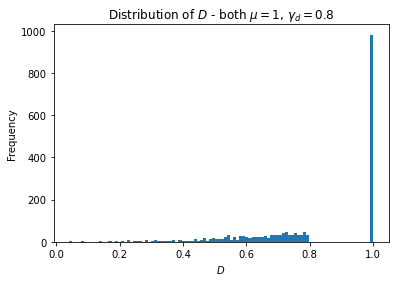

In [10]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,1].flatten(), bins = 100)
plt.setp(ax, title = r'Distribution of $D$ - both $\mu=1$, $\gamma_d = 0.8$', xlabel = r'$D$', ylabel = 'Frequency');

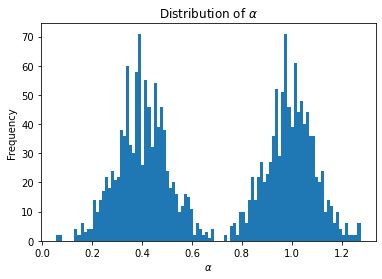

In [34]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,0].flatten(), bins = 100)
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

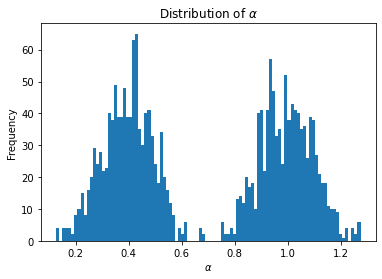

In [32]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,0].flatten(), bins = 100)
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

# Single state model

Non interacting particles, diffusing according to a unique diffusion state with BM or FBM of different $H$.

## Single trajectory generator

Input:
- $T$: (scalar) Length of the trajectory
- $D$: (scalar) Diffusion coefficient (defined as the square root of the standard deviation of the displacements).
- $\alpha$: (scalar) anomalous exponent.
- $L$: (scalar) size of the squared box acting as environment. If `None`, the system is infinite.

Output:
- pos: (array of size $T\times 2$) Position of the particle at each timestep.
- labels: (array of size $T\times 3$) Anomalous exponent, D and state at each timestep. In this case, the state is alway 'free'.


In [14]:
#export
class models_phenom(models_phenom):
    
    @staticmethod
    def _single_state_traj(T = 200, 
                          D = 1, 
                          alpha = 1, 
                          L = None,
                          deltaT = 1):
        
        # Trajectory displacements
        dispx, dispy = models_phenom().disp_fbm(alpha, D, T), models_phenom().disp_fbm(alpha, D, T)
        # Labels
        lab_diff_state = np.ones(T)*models_phenom().lab_state.index('f') if alpha < models_phenom().alpha_directed else np.ones(T)*models_phenom().lab_state.index('d')
        labels = np.vstack((np.ones(T)*alpha, 
                            np.ones(T)*D,
                            lab_diff_state
                           )).transpose()

        # If there are no boundaries
        if not L:
            posx, posy = np.cumsum(dispx) - dispx[0], np.cumsum(dispy) - dispy[0]

            return np.vstack((posx, posy)).transpose(), labels

        # If there are, apply reflecting boundary conditions
        else:
            pos = np.zeros((T, 2))

            # Initialize the particle in a random position of the box
            pos[0, :] = np.random.rand(2)*L
            for t in range(1, T):
                pos[t, :] = [pos[t-1, 0]+dispx[t], pos[t-1, 1]+dispy[t]]            


                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]

            return pos, labels

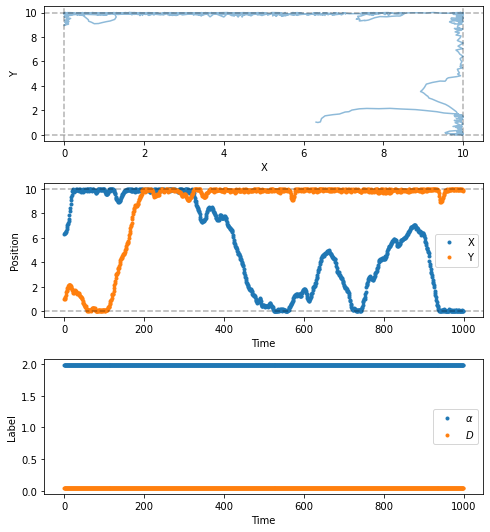

In [16]:
traj, labels = models_phenom._single_state_traj(D = 0.05, T =1000, alpha = 1.98, L = 10)

fig, ax = plt.subplots(3, 1, figsize = (7, 7.5), tight_layout = True)
ax[0].plot(traj[:, 0], traj[:, 1], alpha = 0.5)
plt.setp(ax[0], xlabel = 'X', ylabel = 'Y')
ax[0].axhline(10, ls = '--', alpha = 0.3, c = 'k')
ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
ax[0].axvline(10, ls = '--', alpha = 0.3, c = 'k')
ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')

ax[1].plot(traj[:, 0], '.', label = 'X')
ax[1].plot(traj[:, 1], '.', label = 'Y', )
plt.setp(ax[1], ylabel = 'Position', xlabel = 'Time')
ax[1].axhline(10, ls = '--', alpha = 0.3, c = 'k')
ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
ax[1].legend()

ax[2].plot(labels[:, 0], '.', label = r'$\alpha$')
ax[2].plot(labels[:, 1], '.', label = r'$D$' )
plt.setp(ax[2], ylabel = 'Label', xlabel = 'Time')
ax[2].legend()


## Dataset generation

Input:
- $N$: (scalar) Number of trajectories in the dataset
- $T$: (scalar) Length of the trajectory
- $D$: (scalar) Diffusion coefficient (defined as the square root of the standard deviation of the displacements).
- $\alpha$: (scalar) anomalous exponent.
- $L$: (scalar) size of the squared box acting as environment. If `None`, the system is infinite.

In [43]:
#export
class models_phenom(models_phenom):
    
    
    def single_state(self,
                     N = 10,
                     T = 200, 
                     Ds = [1, 0], 
                     alphas = [1, 0], 
                     L = None):

        data = np.zeros((T, N, 2))
        labels = np.zeros((T, N, 3))

        for n in range(N):
            alpha_traj = gaussian(alphas, bound = self.bound_alpha)
            D_traj = gaussian(Ds, bound = self.bound_D)
            # Get trajectory from single traj function
            pos, lab = self._single_state_traj(T = T, 
                                   D = D_traj, 
                                   alpha = alpha_traj, 
                                   L = L)        
            data[:, n, :] = pos
            labels[:, n, :] = lab

        return data, labels

In [45]:
N = 500; L = 5; T = 100;
alpha = [0.8, 0.1]; D = 1.2

trajs, labels = models_phenom().single_state(N = N,
                                           L = L,
                                           T = T, 
                                           alphas = alpha,
                                           Ds = D)

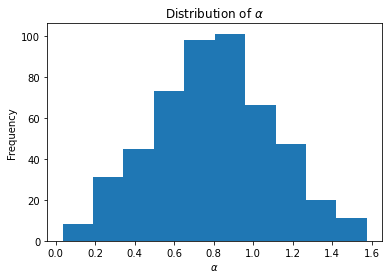

In [46]:
fig, ax = plt.subplots()
ax.hist(labels[0,:,0])
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

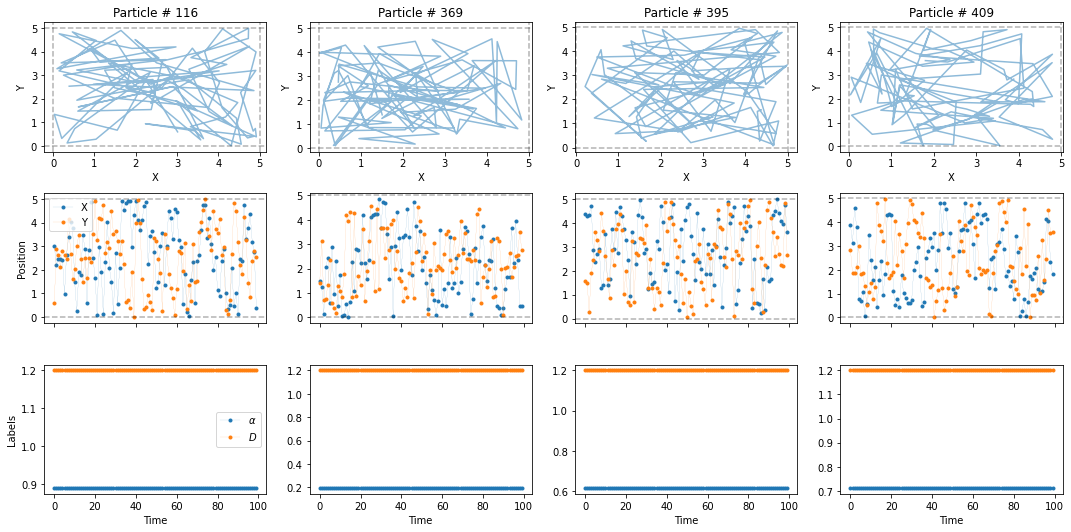

In [47]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for ax in axs.transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

# Multiple state model

Particles diffusing according to a time-dependent $N$-state model of diffusion, representing proteins undergoing changes of diffusivity and/or $H$ induced by, e.g. allosteric changes or ligand-binding.

## Single trajectory generator

Input:
- $T$: (scalar) lenght of the trajectory
- $M$: (matrix) Transition matrix stating the probability of switching between states at each time step.
- $D$s: (scalar or vector) diffusion coefficient of each state. If scalar, all segments have same value.
- $\alpha$s (alphas): (scalar or vector) anomalous exponent of each state. If scalar, all segments have same value.
- $L$: (scalar) size of the squared box acting as environment. If `None`, the system is infinite.

In [7]:
#export
class models_phenom(models_phenom):
    
    @staticmethod
    def _multiple_state_traj(T = 200,
                    M = np.array([[0.9 , 0.1],[0.1 ,0.9]]),
                    Ds = np.array([1, 0.1]), # Diffusion coefficients of two states
                    alphas = np.array([1, 1]), # Anomalous exponents for two states
                    L = None,
                    deltaT = 1,
                    return_state_num = False, # if True, returns the number assigned to the curren state
                    init_state = None
                            ):
        
        # transform lists to numpy if needed
        if isinstance(M, list):
            M = np.array(M)
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)


        pos = np.zeros((T, 2))
        if L: pos[0,:] = np.random.rand(2)*L

        # Diffusing state of the particle
        state = np.zeros(T).astype(int)
        if init_state is None:
            state[0] = np.random.randint(M.shape[0])
        else: state[0] = init_state
        
        # Init alphas, Ds
        alphas_t = np.array(alphas[state[0]]).repeat(T)
        Ds_t = np.array(Ds[state[0]]).repeat(T)
        
        
        # Trajectory displacements    
        dispx, dispy = [models_phenom().disp_fbm(alphas_t[0], Ds_t[0], T),
                        models_phenom().disp_fbm(alphas_t[0], Ds_t[0], T)]


        for t in range(1, T):

            pos[t, :] = [pos[t-1, 0]+dispx[t], pos[t-1, 1]+dispy[t]]  

            # at each time, check new state
            state[t] = np.random.choice(np.arange(M.shape[0]), p = M[state[t-1], :])


            if state[t] != state[t-1]:
                
                alphas_t[t:] =  np.array(alphas[state[t]]).repeat(T-t)  
                Ds_t[t:] = np.array(Ds[state[t]]).repeat(T-t)
                
                
                # Recalculate new displacements for next steps
                if len(dispx[t:]) > 1:                    
                    dispx[t:], dispy[t:] = [models_phenom().disp_fbm(alphas_t[t], Ds_t[t], T-t),
                                            models_phenom().disp_fbm(alphas_t[t], Ds_t[t], T-t)]
                        
                        
                else: 
                    dispx[t:], dispy[t:] = [np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn(), 
                                            np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn()]
                    

            if L is not None:
                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]
                    
        # Define state of particles based on values of alphas: either free or directed
        label_diff_state = np.zeros_like(alphas_t)
        label_diff_state[alphas_t  < models_phenom().alpha_directed] = models_phenom().lab_state.index('f')
        label_diff_state[alphas_t >= models_phenom().alpha_directed] = models_phenom().lab_state.index('d')
                    
        if return_state_num:            
            return pos, np.array((alphas_t,
                                  Ds_t,
                                  label_diff_state,
                                  state)).transpose()
        else: 
            return pos, np.array((alphas_t,
                                  Ds_t,
                                  label_diff_state)).transpose()
        


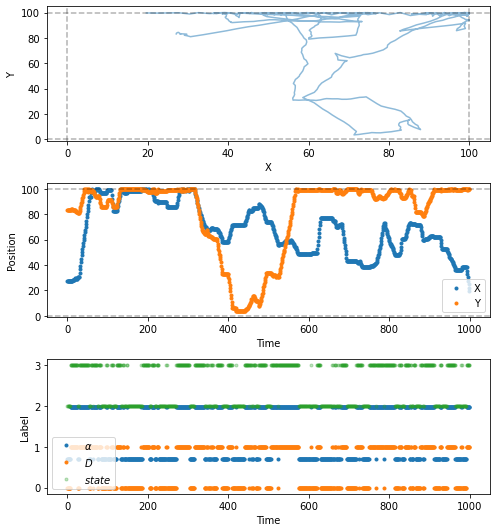

In [11]:
T = 1000; L = 100
X = models_phenom._multiple_state_traj(T = T,
                                       L = L,
                                       alphas = [0.7, 1.98], Ds = [0, 1], return_state_num=True)


traj = X[0]; labels = X[1]
# traj, labels = multiple_states(T = 1000,
#                            L = 10,
#                            M = np.array([[0.8 , 0.1, 0.1],[0.01, 0.98, 0.01],[0, 0.05 ,0.95]]),
#                            alphas = [0.8, 1.2, 1.4],
#                            Ds = [1, 0, 2])

fig, ax = plt.subplots(3, 1, figsize = (7, 7.5), tight_layout = True)
ax[0].plot(traj[:, 0], traj[:, 1], alpha = 0.5)
plt.setp(ax[0], xlabel = 'X', ylabel = 'Y')
ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')

ax[1].plot(traj[:, 0], '.', label = 'X')
ax[1].plot(traj[:, 1], '.', label = 'Y', )
plt.setp(ax[1], ylabel = 'Position', xlabel = 'Time')
ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
ax[1].legend()

ax[2].plot(labels[:, 0], '.', label = r'$\alpha$')
ax[2].plot(labels[:, 1], '.', label = r'$D$' )
ax[2].plot(labels[:, 2], '.', label = r'$state$', alpha = 0.3 )

plt.setp(ax[2], ylabel = 'Label', xlabel = 'Time')
ax[2].legend()

## Dataset generation

Input:
- $N$: (scalar) Number of trajectories in the dataset
- Inputs of `multiple_states`

In [8]:
#export
class models_phenom(models_phenom):
    def multi_state(self,
                    N = 10,
                    T = 200,
                    M = np.array([[0.9 , 0.1],[0.1 ,0.9]]),
                    Ds = np.array([[1, 0], [0.1, 0]]), 
                    alphas = np.array([[1, 0], [1, 0]]), 
                    gamma_d = [1], # minimum distance between state's D
                    epsilon_a = [0], # mininum distance between state's alpha
                    L = None,
                    return_state_num = False,
                    init_state = None): 
        
        

        trajs = np.zeros((T, N, 2))
        if return_state_num:
            labels = np.zeros((T, N, 4))
        else:
            labels = np.zeros((T, N, 3))

        for n in range(N):
            
            ### Sampling diffusion parameters for each state
            alphas_traj = []
            Ds_traj = []
            
            alphas_traj, Ds_traj = self._sample_diff_parameters(alphas = alphas,
                                                                Ds = Ds,
                                                                num_states = M.shape[0],
                                                                epsilon_a = epsilon_a,
                                                                gamma_d = gamma_d)
                    
            #### Get trajectory from single traj function
            traj, lab = self._multiple_state_traj(T = T,
                                                  L = L,
                                                  M = M,
                                                  alphas = alphas_traj,
                                                  Ds = Ds_traj,
                                                  return_state_num = return_state_num,
                                                  init_state = init_state
                                                 )  
                
            trajs[:, n, :] = traj
            labels[:, n, :] = lab 
            
        return trajs, labels

In [19]:
N = 1000; L = 50; T = 10;

trajs, labels = models_phenom().multi_state(N = N,
                                       T = T,
                                       L = L,
                                       M = np.array([[0.95 , 0.05],[0.01, 0.99]]),
                                        Ds = np.array([[1, 0], [0.5, 0.01]]), 
                                        alphas = np.array([[1, 0.01], [0.5, 0.02]]),
                                            epsilon_a=[0.4], gamma_d = [0.2],
                                                      return_state_num=True)

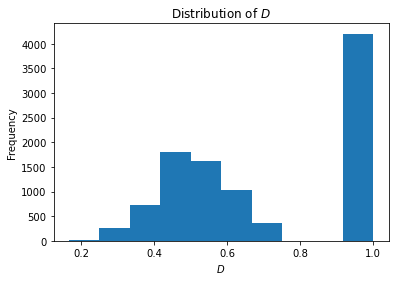

In [20]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,1].flatten())
plt.setp(ax, title = r'Distribution of $D$', xlabel = r'$D$', ylabel = 'Frequency');

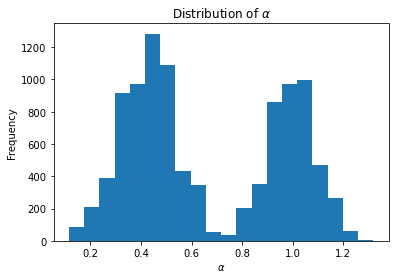

In [21]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,0].flatten(), bins = 20)
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

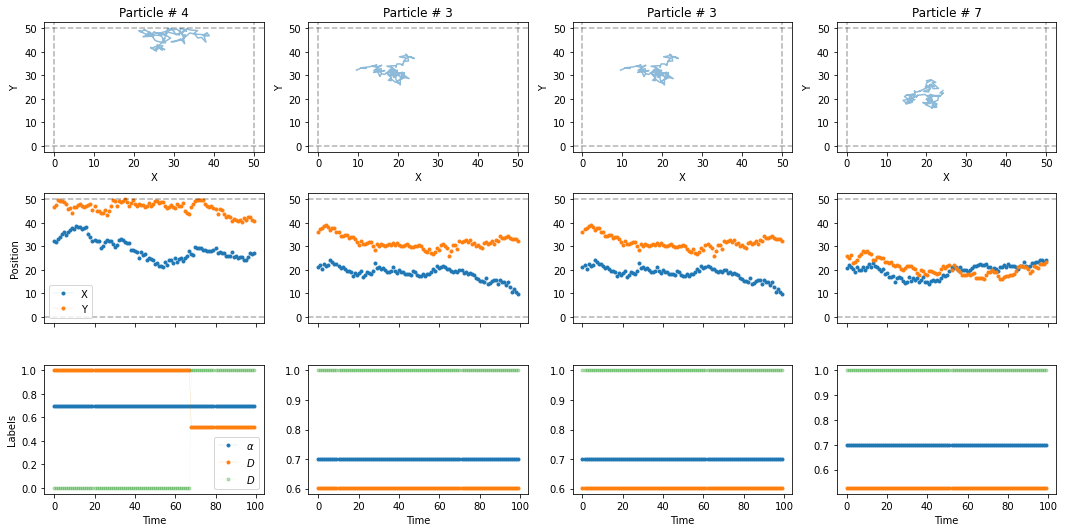

In [226]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for ax in axs.transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, -1], 'o-', label = r'$D$', ms = 3, lw = 0.1, alpha = 0.3)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

# Dimerization

Particle diffusing according to a space-dependent 2-state model of diffusion, representing proteins being confined by immobile traps induced by, e.g. the actin cytoskeleton or clathrin-coated pits.

## Auxiliary functions

**Distance calculator**

In [14]:
#export
class models_phenom(models_phenom):
    @staticmethod
    def _get_distance(x):
        M = np.reshape(np.repeat(x[ :, :], x.shape[0], axis = 0), (x.shape[0], x.shape[0], 2))
        Mtrans = M.transpose(1,0,2)
        distance = np.sqrt(np.square(M[:,:, 0]-Mtrans[:,:, 0])
                         + np.square(M[:,:, 1]-Mtrans[:,:, 1]))  
        return distance

**Escaping dynamics**

In [15]:
#export
class models_phenom(models_phenom):
    @staticmethod
    def _make_escape(Pu, label, diff_state):

        # if unbinding probability is zero
        if Pu == 0:
            return label, diff_state

        label = label.copy()
        diff_state = diff_state.copy()

        label_dimers = np.unique(label[np.argwhere(diff_state == 1)])

        for l in label_dimers:         

            if np.random.rand() < Pu:
                # give new label to escaping particles
                diff_state[label == l] = 0
                label[label == l] = np.max(label)+np.arange(2)+1

        return label, diff_state

**Clustering dynamics**

In [16]:
#export
class models_phenom(models_phenom):
    @staticmethod
    def _make_condensates(Pb, label, diff_state, r, distance, max_label):

        label = label.copy()
        diff_state = diff_state.copy()

        # Keeping track of the ones that will dimerize
        already_dimer = []

        for n, l in enumerate(label):

            # Consider conditions in which particles do not dimerize
            if n in already_dimer or diff_state[n] == 1 or l > max_label:
                continue

            # Extract distances to current particle
            distance_to_current = distance[n,:]
            distance_to_current[n] == 0
            close_particles = np.argwhere((distance_to_current < 2*r) & (distance_to_current > 0)).flatten()

            # Loop over all posible dimerizing candidates
            for chosen in close_particles:

                # Consider conditions in which particles do not dimerize
                if chosen in already_dimer or diff_state[chosen] == 1 or label[chosen] > max_label: 
                    continue

                # Draw coin to see if particle dimerizes
                if np.random.rand() < Pb:                                 
                    # Add dimerized particles to the new dimer counter
                    already_dimer.append(chosen)
                    already_dimer.append(n)
                    # Update their diffusive state
                    diff_state[n] = 1
                    diff_state[chosen] = 1 

                    # dimerize particles
                    label[chosen] = l

                    # if one particles dimers, not more clustering!
                    break

        return label, diff_state

In [111]:
N = 200; L = 10; r = 1; max_n = 2; Ds = np.ones(100)

pos = np.random.rand(N, 2)*L    
label = np.random.choice(range(500), N, replace = False)
max_label = max(label+2)
distance = models_phenom._get_distance(pos)
diff_state = np.zeros(N).astype(int)

l, d = models_phenom._make_condensates(0.01, label, diff_state, r, distance, max_label)
le, de = models_phenom._make_escape(0.8, l, d)

np.unique(l[np.argwhere(d == 1)], return_counts=True)

(array([  8,  54, 101, 119, 144, 162, 176, 251, 283, 296, 304, 305, 346,
        397, 416, 444, 476]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))

**Stokes drag**

In [17]:
class models_phenom(models_phenom):
    @staticmethod
    def _stokes(D):
        ''' Applies a Stokes-Einstein -like transformation to two
        diffusion coefficients '''
        D1 = D[0]; D2 = D[1]
        return 1/((1/D1)+(1/D2))

## Time evolution

Input:
- $N$: (scalar) number of particles
- $T$: (scalar) length of the trajectory
- $L$: (scalar) length of the squared box acting as environment
- $r$: (scalar) size of the particles
- $P_u$: (scalar) unbinding probability
- $P_b$: (scalar) binding probability
- $D$s: (2 x 3 array) $(a,b,c)$ parameters of the Pert distribution defining the diffusion coefficients for the two diffusive states.
- $\alpha$s: (2 x 3 array) $(a,b,c)$ parameters of the Pert distribution defining the anomalous exponent for the two diffusive states.
- $\gamma$s: (bool or float) if float, the $D_{dimer} = \mathrm{mean}(D_1, D_2)/\gamma$

In [18]:
#export
class models_phenom(models_phenom):
    def dimerization(self,
                     N = 10,
                     T = 200,                
                     L = 100,
                     r = 1,
                     Pu = 0.1, # Unbinding probability
                     Pb = 0.01, # Binding probability
                     Ds = np.array([[1, 0], [0.1, 0]]), # Diffusion coefficients of two states
                     alphas = np.array([[1, 0], [1, 0]]), # Anomalous exponents for two states
                     deltaT = 1,
                     gamma = False,
                     return_state_num = False,
                     epsilon_a = 0, stokes = False
                     ):
        
        # transform lists to numpy if needed
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        # Info to save
        pos = np.zeros((T, N, 2)) # position over time
        label = np.zeros((T, N)).astype(int)
        diff_state = np.zeros((T, N)).astype(int)

        # Init position, labels     
        pos[0, :, :] = np.random.rand(N, 2)*L    
        label[0, :] = np.arange(pos.shape[1])
        
        # Init alphas, Ds
        # Calculate alpha/D for each particle in each state
        alphas_N = np.array([gaussian(alphas[0], size = N, bound = self.bound_alpha),
                             gaussian(alphas[1], size = N, bound = self.bound_alpha)])
        Ds_N = np.array([gaussian(Ds[0], size = N, bound = self.bound_D),
                         gaussian(Ds[1], size = N, bound = self.bound_D)])
        # define labels over time by means of state 0
        alphas_t = alphas_N[0,:].repeat(T).reshape(N,T).transpose()
        Ds_t = Ds_N[0,:].repeat(T).reshape(N,T).transpose()
        
                
        # initial displacements (all free particles)
        disps = np.zeros((T, N, 2))
        for n in range(N):            
            disps[:, n, 0] = models_phenom().disp_fbm(alphas_t[0, n], Ds_t[0, n], T, deltaT = deltaT)
            disps[:, n, 1] = models_phenom().disp_fbm(alphas_t[0, n], Ds_t[0, n], T, deltaT = deltaT)
   
        for t in (range(1, T)):

            # Find max label to account later for escaped
            max_label = np.max(label[t-1, :])

            # Make particles escape
            label[t, :], diff_state[t, :] = self._make_escape(Pu,
                                                              label[t-1, :], 
                                                              diff_state[t-1, :])

            lab, diff = label[t, :].copy(), diff_state[t, :].copy()

            # get distance + increasing it for escaped to avoid reclustering
            distance = self._get_distance(pos[t-1, :, :])

            # Merge particles in condensates
            label[t, :], diff_state[t, :] = self._make_condensates(Pb,
                                                                 label[t, :],
                                                                 diff_state[t, :],
                                                                 r, distance, max_label)

            # Find particles which changed state
            label_changed, counts = np.unique(label[t, np.not_equal(diff_state[t-1,:], diff_state[t,:])], 
                                              return_counts = True)

            # Calculate new displacements for particles which changed state
            for l, count in zip(label_changed, counts):

                index = int(np.argwhere(label[t,:] == l)[0])
                state = diff_state[t, index]
                
                
                ### Calculating new diffusion parameters
                # anomalous exponent
                if epsilon_a != 0 and state == 1:                    
                    new_alpha = gaussian(alphas[1], size = 1, bound = self.bound_alpha)
                    idx_while = 0
                    while models_phenom()._constraint_alpha(alphas_N[0, label[t, :] == l].min(), new_alpha, epsilon_a):
                        new_alpha = gaussian(alphas[1], size = 1, bound = self.bound_alpha)
                        idx_while += 1
                        if idx_while > 100: # check that we are not stuck forever in the while loop
                            raise FileNotFoundError(f'Could not find correct alpha in 100 steps. State distributions probably too close.')
                    alphas_t[t:, label[t, :] == l] = new_alpha
                else: 
                    # if no epsilon is given, use the alpha of the first particle
                    # While here it seems we take both, in the for loop where we assign the displacements below we only
                    # sample with the first value.
                    alphas_t[t:, label[t, :] == l] = alphas_N[state, label[t, :] == l].repeat(T-t).reshape(count, T-t).transpose()
                    
                # diffusion coefficient
                if stokes and state == 1:
                    Ds_t[t:, label[t, :] == l] = models_phenom()._stokes(Ds_t[t-1, label[t, :] == l])
                else: # if no stokes is given, use the alpha of the first particle (see alpha sampling for more details)
                    Ds_t[t:, label[t, :] == l] = Ds_N[state, label[t, :] == l].repeat(T-t).reshape(count, T-t).transpose()
                    
                for idx, i in enumerate(np.argwhere(label[t,:] == l)):
                    # We first calculate the displacements so dimers have same motion
                    if idx == 0:                        
                        if T-t > 1:                       
                            disp_current_x = models_phenom().disp_fbm(float(alphas_t[t, i]), float(Ds_t[t, i]), T-t, deltaT = deltaT).reshape(T-t, 1)
                            disp_current_y = models_phenom().disp_fbm(float(alphas_t[t, i]), float(Ds_t[t, i]), T-t, deltaT = deltaT).reshape(T-t, 1)
                        else: 
                            disp_current_x = np.sqrt(2*float(Ds_t[t, i])*deltaT)*np.random.randn(1)
                            disp_current_y = np.sqrt(2*float(Ds_t[t, i])*deltaT)*np.random.randn(1)
                            
                    disps[t:, i, 0] = disp_current_x
                    disps[t:, i, 1] = disp_current_y

            # Update position
            pos[t, :, :] = pos[t-1,:,:]+disps[t, :, :]
            # Consider boundary conditions
            if L is not None:
                while np.max(pos[t,:, :])>L or np.min(pos[t,:, :])< 0: 
                    pos[t, pos[t,:, :] > L] = pos[t, pos[t,:, :] > L] - 2*(pos[t, pos[t,:, :] > L] - L)
                    pos[t, pos[t,:, :] < 0] = - pos[t, pos[t,:, :] < 0]  
        
        # Define state of particles based on values of alphas: either free or directed            
        label_diff_state = np.zeros_like(alphas_t)
        label_diff_state[alphas_t  < self.alpha_directed] = self.lab_state.index('f')
        label_diff_state[alphas_t >= self.alpha_directed] = self.lab_state.index('d')
        
        if return_state_num:
            return pos, np.array((alphas_t,
                                  Ds_t, 
                                  label_diff_state,
                                  diff_state)).transpose(1,2,0)
        else:
            return pos, np.array((alphas_t,
                                  Ds_t, 
                                  label_diff_state
                                 )).transpose(1,2,0)
    

In [19]:
N = 500; L = 50; r = 1; T = 100
Pu = 0.1 # Unbinding probability
Pb = 1 # Binding probability
Ds = np.array([[2, 0], [0, 0]]) # Diffusion coefficients of two states
alphas = np.array([[1, 0], [1, 0.2]]) # Anomalous exponents for two states

trajs, labels = models_phenom().dimerization(N = N,
                                            L = L,
                                            r = r,
                                            T = T,
                                            Pu = Pu, # Unbinding probability
                                            Pb = Pb, # Binding probability
                                            Ds = Ds, # Diffusion coefficients of two states
                                            alphas = alphas, # Anomalous exponents for two states,
                                            gamma = 3,
                                            return_state_num = True,
                                            stokes = True, epsilon_a=0.2
                                            )


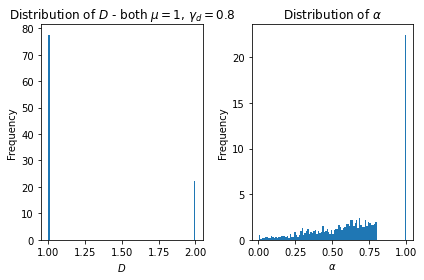

In [20]:
fig, ax = plt.subplots(1,2, tight_layout = True)
ax[0].hist(labels[:,:,1].flatten(), bins = 100, density = 1)
plt.setp(ax[0], title = r'Distribution of $D$ - both $\mu=1$, $\gamma_d = 0.8$', xlabel = r'$D$', ylabel = 'Frequency');
ax[1].hist(labels[:,:,0].flatten(), bins = 100, density = 1)
plt.setp(ax[1], title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

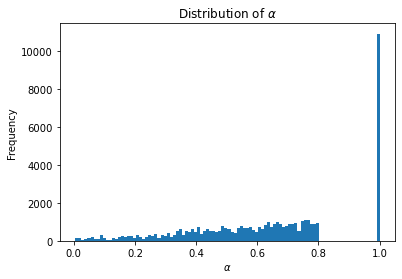

In [197]:
fig, ax = plt.subplots()
ax.hist(labels[:,:,0].flatten(), bins = 100)
plt.setp(ax, title = r'Distribution of $\alpha$', xlabel = r'$\alpha$', ylabel = 'Frequency');

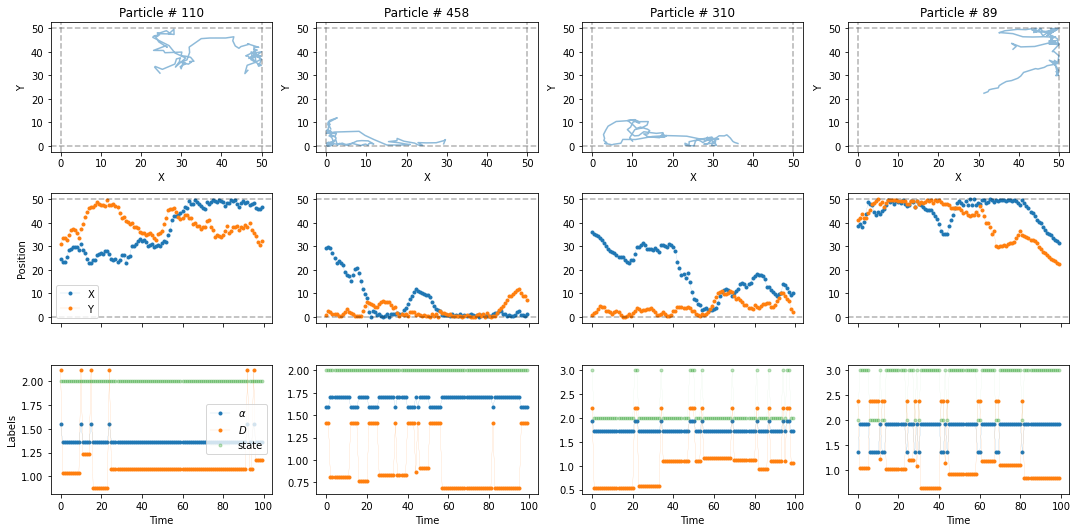

In [175]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for idx, ax in enumerate(axs.transpose()):
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 2], 'o-', label = r'state', ms = 3, lw = 0.1, alpha = 0.3)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

# plt.savefig('dimerization.svg')

# Immobile traps

In [38]:
#export
class models_phenom(models_phenom):
    @staticmethod
    def _update_bound(mask, # current bind vector
                         N, # number of particles
                         pos, # position of particles
                         Nt, # number of traps
                         traps_pos, # position of traps
                         Pb, # binding probability
                         Pu, # unbinding probability
                         r, # trap radius
                        ):

        # from the ones that are bound, get the ones that unbind. These will be descarted for binding in same time step
        mask_new_free = np.array(1-(np.random.rand(N) < Pu)*mask).astype(bool)

        # calculate the distance between traps and particles
        d = models_phenom._get_distance(np.vstack((traps_pos, pos)))[Nt:, :Nt]
        mask_close = (d < r).sum(1).astype(bool)

        # get mask for binding
        mask_new_bind = np.random.rand(N) < Pb

        # update the bound vector with the previous conditions:
        # first, the ones that unbind
        mask *= mask_new_free
        # then, the ones that are close + bind. Mask_new_free is added to avoid binding
        # of the ones that just unbound
        mask += mask_close*mask_new_bind*mask_new_free

        return mask

In [46]:
#export
class models_phenom(models_phenom):

    def immobile_traps(self,
                       N = 10,
                       T = 200,                
                       L = 100,
                       r = 1,
                       Pu = 0.1, # Unbinding probability
                       Pb = 0.01, # Binding probability
                       Ds = [1, 0], # Diffusion coefficients of moving state
                       alphas = [1, 0], # Anomalous exponents of moving state
                       Nt = 10,
                       traps_pos = None,
                       deltaT = 1
                      ): 

        # Info to output
        pos = np.zeros((T, N, 2)) # position over time
        output_label = np.zeros((T, N, 3))        

        disps = np.zeros((T, N, 2)) 
        diff_state = np.zeros((T, N)).astype(int)
        mask_bound = diff_state[0, :].astype(bool)

        # Init position, labels     
        pos[0, :, :] = np.random.rand(N, 2)*L
        
        # Init alphas, Ds
        # Calculate alpha/D for each particle in state free state
        alphas_N = gaussian(alphas, size = N, bound = self.bound_alpha)
        Ds_N = gaussian(Ds, size = N, bound = self.bound_D)

        # Traps positions
        if traps_pos is None:
            traps_pos = np.random.rand(Nt, 2)*L              
            
        # Get displacement for every particle
        for n in range(N):            
            disps[:, n, 0] = models_phenom().disp_fbm(alphas_N[n], Ds_N[n], T, deltaT = deltaT)
            disps[:, n, 1] = models_phenom().disp_fbm(alphas_N[n], Ds_N[n], T, deltaT = deltaT)
            
        # Set initial values of labels
        output_label[0, :, 0] = alphas_N
        output_label[0, :, 1] = Ds_N

        for t in (range(1, T)):

            mask_bound = self._update_bound(mask = mask_bound, # current bind vector
                                         N = N, # number of particles
                                         pos = pos[t-1, :, :], # position of particles
                                         Nt = Nt, # number of traps
                                         traps_pos = traps_pos, # position of traps
                                         Pb = Pb, # binding probability
                                         Pu = Pu, # unbinding probability
                                         r = r, # trap radius
                                         )
            # Update the diffusive state
            diff_state[t,:] = mask_bound

            # Regenerate trajectories for untrapped particles
            untrapped = np.argwhere((diff_state[t,:] - diff_state[t-1,:]) == -1).flatten()
            for un_part in untrapped:
                    if T-t > 1:
                        # Recalculate new displacements for next steps                        
                        disps[t:, un_part, 0] = models_phenom().disp_fbm(alphas_N[un_part], Ds_N[un_part], T-t, deltaT = deltaT)
                        disps[t:, un_part, 1] = models_phenom().disp_fbm(alphas_N[un_part], Ds_N[un_part], T-t, deltaT = deltaT)

                    else: 
                        disps[t:, un_part, 0] = np.sqrt(2*Ds_N[un_part]*deltaT)*np.random.randn() 
                        disps[t:, un_part, 1] = np.sqrt(2*Ds_N[un_part]*deltaT)*np.random.randn()

            # Update the position
            pos[t, :, :] = pos[t-1, :, :] + (1-mask_bound).reshape(N,1)*disps[t, :, :]

            # Update labels
            output_label[t, :, 0] = alphas_N*(1-mask_bound)
            output_label[t, :, 1] = Ds_N*(1-mask_bound)

            # Consider boundary conditions
            if L is not None:
                while np.max(pos[t,:, :])>L or np.min(pos[t,:, :])< 0: 
                    pos[t, pos[t,:, :] > L] = pos[t, pos[t,:, :] > L] - 2*(pos[t, pos[t,:, :] > L] - L)
                    pos[t, pos[t,:, :] < 0] = - pos[t, pos[t,:, :] < 0]
                    
        # Define state of particles based on values of Ds and alphas. Here, we use the fact 
        # that alpha = 0 for immobilization
        output_label[output_label[:,:,0] == 0, -1] = self.lab_state.index('i')
        idx_f = np.argwhere
        output_label[(output_label[:,:,0] > 0) & (output_label[:,:,0] < self.alpha_directed), -1] = self.lab_state.index('f')
        output_label[output_label[:,:,0] > self.alpha_directed, -1] = self.lab_state.index('d')

        return pos, output_label

In [49]:
traps_pos = None
alpha = 1.95
D = [1, 0.2]
T = 100
Pb = 1
Pu = 0.1
L = 100

N = 50
Nt = 100
r = 1

traps_pos = np.random.rand(Nt, 2)*L 

trajs, labels = models_phenom().immobile_traps(N = N,
                            T = T,                
                            L = L,
                            r = r,
                            Pu = Pu, # Unbinding probability
                            Pb = Pb, # Binding probability
                            Ds = D, # Diffusion coefficients of moving state
                            alphas = alpha, # Anomalous exponents of moving state
                            Nt = Nt,
                            traps_pos = traps_pos
                            )

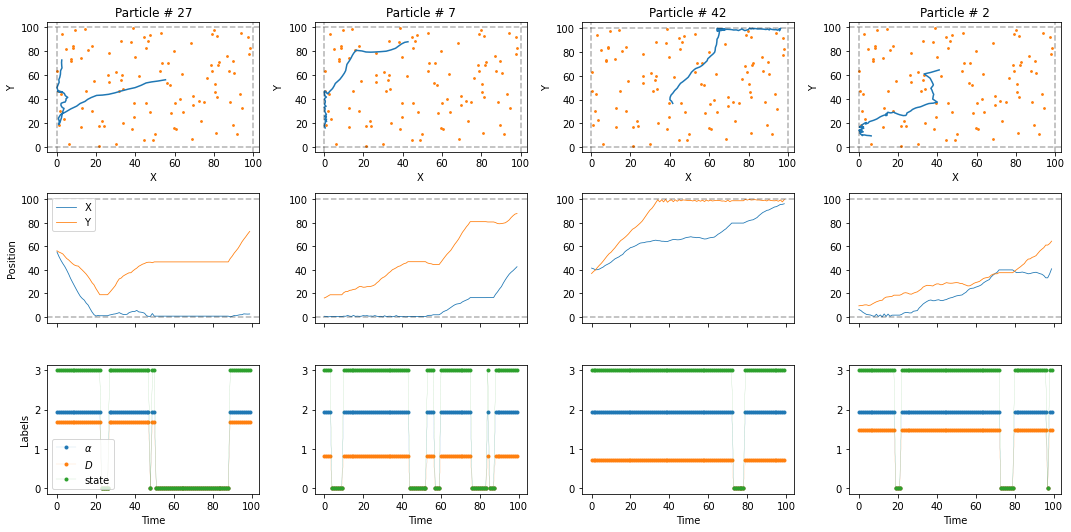

In [50]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)


for ax in axs.transpose():
    
    ax[0].scatter(traps_pos[:,0], traps_pos[:,1], c = 'C1', s = np.pi*r**2)
    
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1])
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[:, part, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 2], 'o-', label = r'state', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

In [49]:
traps_pos = None
alpha = 1.95
D = [1, 0.2]
T = 100
Pb = 1
Pu = 0.1
L = 100

N = 50
Nt = 100
r = 1

traps_pos = np.random.rand(Nt, 2)*L 

trajs, labels = models_phenom().immobile_traps(N = N,
                            T = T,                
                            L = L,
                            r = r,
                            Pu = Pu, # Unbinding probability
                            Pb = Pb, # Binding probability
                            Ds = D, # Diffusion coefficients of moving state
                            alphas = alpha, # Anomalous exponents of moving state
                            Nt = Nt,
                            traps_pos = traps_pos
                            )

# Confinement

## Auxiliary functions

### Distribute compartments

In [23]:
#export
class models_phenom(models_phenom):
    
    @staticmethod
    def _distribute_circular_compartments(Nc, r, L):
        '''Distributes circular compartments over an environment without overlapping. Raises a warning and stops when no more compartments can be inserted.
        Arguments:
        :Nc (float): 
            - number of compartments
        :r (float):
            - Size of the compartments
        :L (float):
            - Side length of the squared environment.
        Return:
        :comp_center (numpy.array):
            - Position of the centers of the compartments        
           '''

        comp_center = np.random.rand(1, 2)*(L - 2*r) + r 
        hardness = 0
        while comp_center.shape[0] < Nc:

            new_pos = np.random.rand(2)*(L - 2*r) + r

            distance = np.linalg.norm(comp_center - new_pos, axis = 1)

            if min(distance) > 2*r:
                comp_center = np.vstack((comp_center, new_pos.reshape(1,2)))

            hardness += 1
            if hardness > Nc*100:
                warn_str = f'Could accomodate {comp_center.shape[0]} circles of the {Nc} requested. Increase size of environment or decrease radius of compartments.'
                warnings.warn(warn_str)
                break
        
        return comp_center

(0.0, 256.0)

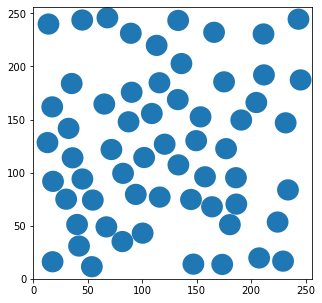

In [23]:
fig, ax = plt.subplots(figsize = (5,5))

Nc = 60; r = 10; L = 256;
comp_center = models_phenom._distribute_circular_compartments(Nc, r, L)

for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r)
    ax.add_patch(circle)
ax.set_xlim(0,L)
ax.set_ylim(0,L)

### Reflection inside circles

In [24]:
#export
from andi_datasets.utils_trajectories import trigo

class models_phenom(models_phenom):
    
    @staticmethod
    def _reflected_position(circle_center, 
                            circle_radius,
                            beg, 
                            end,
                            precision_boundary = 1e-4):
        
        # If the begining of the segment is in the exact boundary, no intersection is found.
        # In that case, we bring closer the point to the center of the cercle so it is
        # at a distance 'precision_boundary' from the border
        if np.linalg.norm(circle_center - beg) > circle_radius - precision_boundary:
            vec = trigo.seg_to_vec([circle_center, beg])
            beg = np.array(circle_center)+(circle_radius-precision_boundary)*(-np.array(vec)/np.dot(vec, vec)**0.5)
            
        # find the intersection between the line drawn by the displacement and the circle
        intersect = trigo.circle_line_segment_intersection(circle_center = circle_center,
                                                           circle_radius = circle_radius, 
                                                           pt1 = beg,
                                                           pt2 = end)[-1]
        # Draw lines and calculate angles between radius and begining-intersection
        line1 = [circle_center, intersect]
        line2 = [beg, intersect]
        angle = trigo.ang_line(line1, line2)
        # Calculate distance between intersection and end of displacement
        dist_int_end = np.linalg.norm(np.array(intersect) - end)
        # Create radius vector and calculate the tangent vector
        vec_radius = trigo.seg_to_vec([circle_center, intersect])
        tangent = trigo.rotate_vec(vec_radius, np.pi/2) 
        # Calculate the angle between the tangent and the displacement vector
        angle_tan = trigo.ang_vec(tangent, trigo.seg_to_vec([beg, intersect]))
        # Change sign to correct get the reflection
        if angle_tan < np.pi/2: angle = - angle
        # Rotate the radius vector with the reflection angle and normalize by magnitude
        vec_bounce = trigo.rotate_vec(vec_radius, angle)
        vec_bounce /= np.dot(vec_bounce, vec_bounce)**0.5
        # Final point is the previous vector times the distance starting at the intersect point  
        return np.array(intersect)+dist_int_end*np.array(vec_bounce), intersect

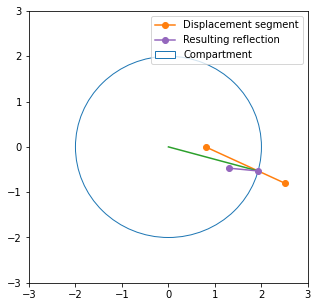

In [607]:
circle_radius = 2;
circle_center = [0,0]
beg = np.array([0.8, 0])+circle_center
end = np.array([2.5, -0.8])+circle_center

final_point, intersect = models_phenom._reflected_position(circle_center, circle_radius, beg, end)

fig, ax = plt.subplots(figsize = (5, 5))

circle = plt.Circle(circle_center, circle_radius, facecolor = 'w', ec = 'C0', label = 'Compartment', zorder = -1)
ax.add_patch(circle)
ax.plot([beg[0],end[0]], [beg[1], end[1]], '-o', c = 'C1', label = 'Displacement segment')
ax.plot([circle_center[0], intersect[0]], [circle_center[1], intersect[1]], c = 'C2')
ax.plot([intersect[0], final_point[0]], [intersect[1], final_point[1]], '-o', c = 'C4', label = 'Resulting reflection')
ax.set_ylim(circle_center[1]-circle_radius*1.5, circle_center[1]+circle_radius*1.5)
ax.set_xlim(circle_center[0]-circle_radius*1.5, circle_center[0]+circle_radius*1.5)
ax.legend()

## Single trajectory generator

In [25]:
#export
class models_phenom(models_phenom):
    
    @staticmethod
    def _confinement_traj(T = 200,
                          Ds = np.array([1, 0.1]),
                          alphas = np.array([1, 1]),
                          L = 100,
                          deltaT = 1,
                          r = 1,
                          comp_center = None,
                          Nc = 10,
                          trans = 0.1):

        
        # transform lists to numpy if needed
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        # Traps positions
        if comp_center is None:
            comp_center = models_phenom._distribute_circular_compartments(Nc = Nc,
                                                                          r = r,
                                                                          L = L)
        # Particle's properties
        pos = np.zeros((T, 2)) 
        pos[0,:] = np.random.rand(2)*L

        state = np.zeros(T).astype(int)        
        # Check if particle is compartment
        distance_centers = np.linalg.norm(comp_center - pos[0, :], axis = 1)
        if distance_centers.min() < r:
            # we assign the state to the compartment the particle is on
            compartment = distance_centers.argmin()
            state[0] = 1

        # Output labels
        labels = np.zeros((T, 3))
        labels[0, 0] = alphas[state[0]] 
        labels[0, 1] = Ds[state[0]]         
        

        # Trajectory
        dispx = models_phenom().disp_fbm(alphas[state[0]], Ds[state[0]], T, deltaT = deltaT)
        dispy = models_phenom().disp_fbm(alphas[state[0]], Ds[state[0]], T, deltaT = deltaT)
        disp_t = 0


        for t in range(1, T):
            pos[t, :] = [pos[t-1, 0]+dispx[disp_t], pos[t-1, 1]+dispy[disp_t]]  

            # if the particle was inside a compartment
            if state[t-1] == 1:

                # check if it exited of the compartment
                current_distance = np.linalg.norm(comp_center[compartment, :] - pos[t, :])                              
                if current_distance > r:                    
                    coin = np.random.rand()                    
                    # particle escaping
                    if coin < trans:                        
                        # check that if we entered in a different comparmetn
                        distance_centers = np.linalg.norm(comp_center - pos[t, :], axis = 1)
                        if distance_centers.min() < r:
                            # we assign the state to the compartment the particle is on
                            compartment = distance_centers.argmin()
                            state[t] = 1
                        else: state[t] = 0

                    # particle reflecting
                    else:   
                        beg = pos[t-1, :]
                        while current_distance > r:

                            pos[t, :], intersect = models_phenom._reflected_position(circle_center = comp_center[compartment, :],
                                                                                     circle_radius = r,
                                                                                     beg = beg,
                                                                                     end = pos[t, :])
                            beg = intersect
                            distance_beg = np.linalg.norm(comp_center[compartment, :] - beg)    
                            current_distance = np.linalg.norm(comp_center[compartment, :] - pos[t,:])  
                        state[t] = 1
                # if the particle stayed inside the compartment
                else: state[t] = 1


            # If particle was outside of the compartment
            elif state[t-1] == 0:                
                # Check if particle entered a new compartment
                distance_centers = np.linalg.norm(comp_center - pos[t, :], axis = 1)
                if distance_centers.min() < r:
                    # we assign the state to the compartment the particle is on
                    compartment = distance_centers.argmin()
                    state[t] = 1
                # if the particle stayed outside the comparments
                else: state[t] = 0

            # If the state changed
            if state[t] != state[t-1]:
                
                if T-t > 1:
                    dispx = models_phenom().disp_fbm(alphas[state[t]], Ds[state[t]], T-t, deltaT = deltaT)
                    dispy = models_phenom().disp_fbm(alphas[state[t]], Ds[state[t]], T-t, deltaT = deltaT)
                    
                else: 
                    dispx, dispy = [np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn(), 
                                    np.sqrt(2*Ds[state[t]]*deltaT)*np.random.randn()]
                disp_t = 0
            # If the state did not change:
            else: disp_t += 1
            
            # Boundary conditions
            if L is not None:
                # Reflecting boundary conditions
                while np.max(pos[t, :])>L or np.min(pos[t, :])< 0: 
                    pos[t, pos[t, :] > L] = pos[t, pos[t, :] > L] - 2*(pos[t, pos[t, :] > L] - L)
                    pos[t, pos[t, :] < 0] = - pos[t, pos[t, :] < 0]


            labels[t, 0] = alphas[state[t]] 
            labels[t, 1] = Ds[state[t]] 
            
        # Define state of particles based on the state array. First free/directed
        if alphas[0] < models_phenom().alpha_directed:
            labels[state == 0, -1] = models_phenom().lab_state.index('f') 
        else:
            labels[state == 0, -1] = models_phenom().lab_state.index('d') 
        # Then confined
        labels[state == 1, -1] = models_phenom().lab_state.index('c')         
        
        return pos, labels
        


[Text(0.5, 0, 'Position'), Text(0, 0.5, 'Time')]

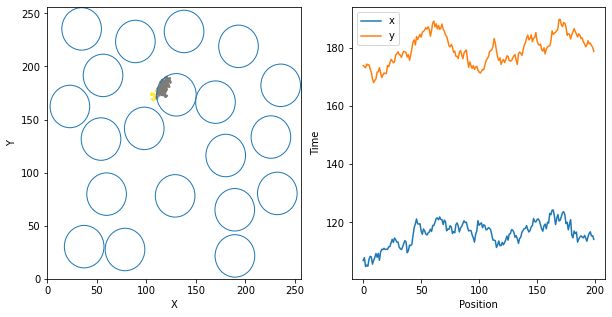

In [335]:
N = 50;  L = 20
Nc = 15; r = 1; L = 20
Ds = [[1,0], [0.5,0.1]]
r , L, Nc = (20, 256, 20)

comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom()._confinement_traj(trans = 0.1, Nc = Nc, r = r, L = L, T =200, comp_center=comp_center, Ds = [1, 1])

fig, axs = plt.subplots(1,2, figsize = (10,5))

ax = axs[0]
for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C0')
    ax.add_patch(circle)    
# ax.plot(trajs[:,0], trajs[:,1], c = 'C1', zorder = -2)   
ax.scatter(trajs[:,0], trajs[:,1], c = plt.cm.cividis(labels[:,-1]/2), zorder = -1, s = 2)   

plt.setp(axs[0], xlim = (0,L), ylim = (0,L), xlabel = 'X', ylabel = 'Y')

axs[1].plot(trajs[:,0], label = 'x');
axs[1].plot(trajs[:,1], label = 'y');
axs[1].legend()
plt.setp(axs[1], xlabel = 'Position', ylabel = 'Time')


## Dataset generation

Input:
- $N$: (scalar) Number of trajectories in the dataset
- Inputs of `_confinement_traj`

In [27]:
#export
class models_phenom(models_phenom):
    def confinement(self,
                    N = 10,
                    T = 200,
                    Ds = np.array([[1, 0], [0.1, 0]]), 
                    alphas = np.array([[1, 0], [1, 0]]),
                    gamma_d = [1], # minimum distance between state's D
                    epsilon_a = [0], # mininum distance between state's alpha
                    L = 100,
                    deltaT = 1,
                    r = 1,
                    comp_center = None,
                    Nc = 10,
                    trans = 0.1):
       
        if isinstance(Ds, list):
            Ds = np.array(Ds)
        if isinstance(alphas, list):
            alphas = np.array(alphas)

        data = np.zeros((T, N, 2))
        labels = np.zeros((T, N, 3))

        for n in range(N):
            
            # Defined physical parameters for each trajectory
            alphas_traj, Ds_traj = self._sample_diff_parameters(alphas = alphas,
                                                                Ds = Ds,
                                                                num_states = 2,
                                                                epsilon_a = epsilon_a,
                                                                gamma_d = gamma_d)

            # Get trajectory from single traj function
            pos, lab = self._confinement_traj(T = T,
                                              Ds = Ds_traj,
                                              alphas = alphas_traj,
                                              L = L,
                                              deltaT = deltaT,
                                              r = r,
                                              comp_center = comp_center,
                                              Nc = Nc,
                                              trans = trans)
            data[:, n, :] = pos
            labels[:, n, :] = lab

        return data, labels

In [33]:
N = 500;  L = 20
Nc = 15; r = 1; L = 20
Ds = [[1,0], [0.5,0.1]]
alphas = [[0.7, 0], [0.5,0.1]]
r , L, Nc = (10, 256, 60)
comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom().confinement(N = N, L = L, comp_center = comp_center, trans = 0.2, Ds = Ds, 
                                            r = r, alphas = alphas, epsilon_a = [0.2])

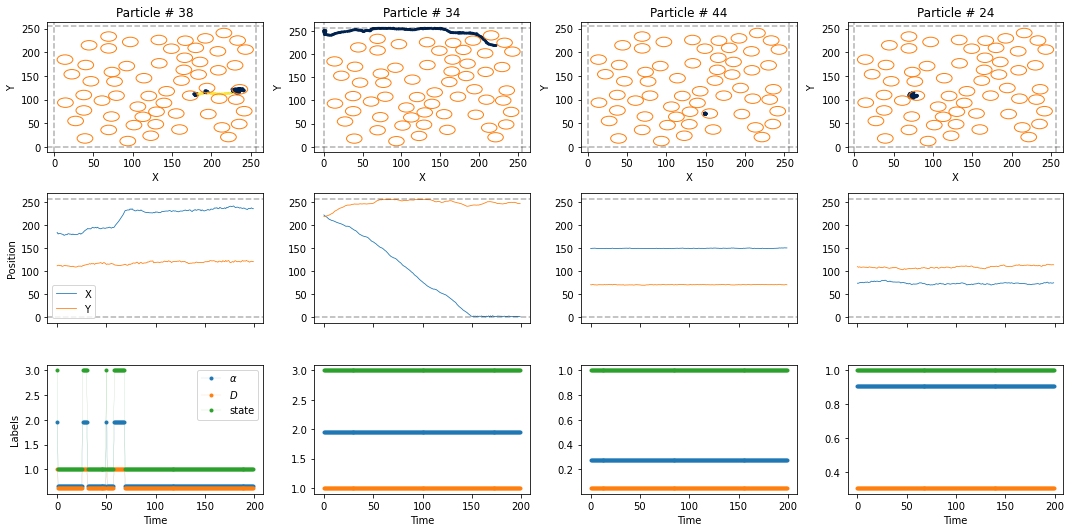

In [57]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)


for ax in axs.transpose():
    
    for c in comp_center:
        circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C1', zorder = 10)
        ax[0].add_patch(circle) 
    
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], zorder = -2)
    ax[0].scatter(trajs[:, part, 0], trajs[:, part, 1], c = labels[:, part, -1]/np.max(labels[:, part, -1]), zorder = -1, s = 4, cmap='cividis')   
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[:, part, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 2], 'o-', label = r'state', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

# NBDEV Export

In [2]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
Converted utils_videos.ipynb.


**To Do**

- [ ] Efficient generation for N particles in model 1 (and 2?)